In [1]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as P
from scipy import stats

import itertools as it
import textwrap

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import decomposition as decomp
from sklearn import preprocessing as prep
from sklearn import manifold as mfold
from sklearn import model_selection as mselection
from sklearn import feature_selection as fselection
from sklearn import metrics as mets
from sklearn import linear_model as lmodel

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

In [2]:
iniN = 3
endN = 52

src = '../hpcc/traditional/'
dst = '../hpcc/results/trad/'

In [3]:
perbasis = 'accession'
filename = src + 'qual_quant_' + perbasis + '_summary.csv'
df = pd.read_csv(filename)

df = df.drop(index = df[df['PercentKernel'] == -1].index)
df['TipShrivel'] /= 100
df['MinorShrivel'] /= 100
df['MajorShrivel'] /= 100
df['PercentKernel'] /= 100

filename = src + 'col_labels.csv'
labels = pd.read_csv(filename, dtype=str, keep_default_na = False)
print(labels.shape)

cattraitnames = df.columns[endN:].values[[12,4,1,3,7,6,11,0,2]]
colnames = df.columns

for i in range(len(colnames)):
    if 'm' in labels.col_units[i]:
        df[colnames[i]] = np.log(df[colnames[i]])

earliest = df[df['EaseOfRemoval'] == 7.5].index.values
data = df.drop(index=earliest)

#lowN = data[data['nut_count'] < 5].index.values
#data = data.drop(index=lowN)

print(df.shape, data.shape)

N = 1000
arr = np.arange(len(data))
testN = int(np.ceil(len(arr)*0.7))

choice = np.zeros((N,testN), dtype=int)
nonchoice = np.zeros((N, len(data) - testN), dtype=int)

for j in range(N):
    rng = np.random.default_rng(j)
    choice[j] = rng.choice(arr, testN, replace=False)
    nonchoice[j] = np.setxor1d(arr, choice[j])
    
df.head()

(67, 2)
(149, 67) (148, 67)


,UCACCSD,nut_count,plot_count,nut_length,nut_height,nut_width,nut_vol,nut_va3d,nut_ratio_feret,nut_area,...,ShellThickness,PackingTissue,KernelFill,TipShrivel,MinorShrivel,MajorShrivel,Plumpness,EaseOfRemoval,PercentKernel,Blank
0,03-001-3395,6,4,3.722851,3.542478,3.546267,10.049243,5.061907,1.205837,8.815960,...,1.075000,5.000000,4.750000,0.000000,0.000000,0.0,4.750000,4.500000,0.623294,0.000000
1,04-004-626,9,1,3.729445,3.590846,3.518564,10.104634,4.624070,1.234757,8.822320,...,1.100000,5.000000,6.000000,0.000000,0.000000,0.0,4.000000,5.000000,0.583988,0.000000
2,06-004-4,16,7,3.612844,3.555183,3.480330,9.937941,4.320171,1.151675,8.687401,...,1.114286,5.000000,5.000000,0.000000,0.031746,0.0,3.857143,4.857143,0.589313,5.714286
3,06-005-27,15,4,3.701885,3.504070,3.436651,9.901554,4.605803,1.304487,8.685413,...,1.475000,5.750000,5.250000,0.000000,0.000000,0.0,3.500000,5.750000,0.482632,2.500000
4,06-030-18,5,3,3.635503,3.496012,3.452446,9.831883,4.443319,1.201473,8.627431,...,1.233333,5.666667,5.666667,0.033333,0.000000,0.0,5.000000,5.666667,0.461030,0.000000


# Choose target variable

In [4]:
data.columns[endN:]

Index(['ShellIntegrity', 'ShellTexture', 'ShellColor', 'SEAL', 'ShellStrength',
       'ShellThickness', 'PackingTissue', 'KernelFill', 'TipShrivel',
       'MinorShrivel', 'MajorShrivel', 'Plumpness', 'EaseOfRemoval',
       'PercentKernel', 'Blank'],
      dtype='object')

../hpcc/results/trad/shelltexture_value_histogram


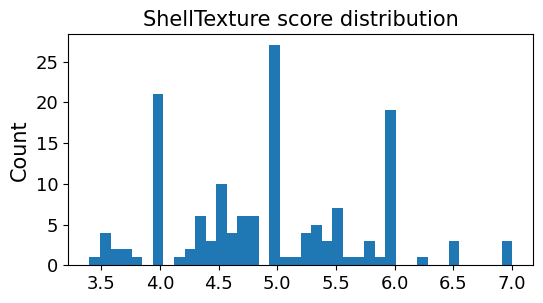

In [6]:
yvalue = 'ShellTexture'
y1 = df[yvalue].values.copy()

fs = 15
fig, ax = plt.subplots(1,1,figsize=(6,3))

ax.hist(y1,bins=40, density=False)
ax.set_title(yvalue + ' score distribution', fontsize=fs)
ax.set_ylabel('Count', fontsize=fs);
ax.tick_params(labelsize=fs-2);

filename = dst + yvalue.lower() + '_value_histogram'
plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

# Spearman correlation

In [7]:
scorrstat = np.ones(endN - iniN)
spvalcorr = np.zeros_like(scorrstat)

for i in range(len(scorrstat)):
    x = df.iloc[:, iniN+i].values
    dof = len(x)-2
    sstat, spval = stats.spearmanr(x, y1)
    #def statistic(x):  # explore all possible pairings by permuting `x`
    #    rs = stats.spearmanr(x, y).statistic  # ignore pvalue
    #    transformed = rs * np.sqrt(dof / ((rs+1.0)*(1.0-rs)))
    #    return transformed
    #ref = stats.permutation_test((x,), statistic, alternative='greater', permutation_type='pairings')

    scorrstat[i] = sstat
    spvalcorr[i] = spval

In [8]:
s_thr = 0.05
s_mask = np.nonzero(spvalcorr < s_thr)[0]
foo = scorrstat[s_mask]
bar = np.argsort(np.abs(foo))[::-1]

for i in range(len(s_mask)):
    print(i+1, -np.log10(spvalcorr[s_mask[bar[i]]]), 
          foo[bar[i]], labels.col_labels.iloc[iniN + s_mask[bar[i]]], sep='\t')

1	30.64856029498142	-0.7772084578697687	Nut Ratio Convex Volume
2	24.70488938791068	-0.7235123162881	Nut Sphericity
3	24.29909277867792	0.7193126588314696	Shell Rugosity
4	23.69896416885416	0.7129584420975671	Nut VA3D
5	19.07480700228635	-0.6574744359166378	Nut Ratio Convex Area
6	3.0205296145769727	0.26794799723182894	Nut Surface Area
7	2.4414376161896776	0.2369559117091371	Shell Volume
8	2.3571327800102457	0.2321086094231828	Shell Vol Ratio wo Air
9	2.3242107408567407	0.2301893915064256	Nut Width
10	2.2556431364897875	-0.22614297958687468	Kernel Vol Ratio
11	2.058014944159394	0.2140840153000256	Nut Convex Surface Area
12	2.0136002140254563	-0.21128728424832519	Kernel Vol Ratio wo Air
13	1.998367934225595	0.21032037788341895	Protruding Shell Volume
14	1.860623791155409	0.2013883522936439	Nut Convex Volume
15	1.6418935253168083	0.18643961502186757	Air Volume
16	1.59947877782946	0.18342031307107554	Nut Height
17	1.4305684786644506	0.17095816707357686	Nut Length
18	1.3710805698507782	-0.

# Find best regularization parameter for Lasso regression

In [9]:
data.iloc[:, iniN+s_mask]

,nut_length,nut_height,nut_width,nut_vol,nut_va3d,nut_area,nut_sphericity,nut_cnvx_area,nut_cnvx_vol,nut_ratio_cnvx_area,nut_inv_ratio_cnvx_vol,air_vol,shell_vol,meat_ratio_vol,shell_rugosity,shell_prot_vol,meat_inv_ratio_cnvx_vol,meat_ratio_vol_sa,shell_ratio_vol_sa
0,3.722851,3.542478,3.546267,10.049243,5.061907,8.815960,0.582681,8.333030,10.106856,0.617099,0.944141,9.199938,7.970302,0.331840,1.716601,4.778839,0.538237,0.579303,0.218403
1,3.729445,3.590846,3.518564,10.104634,4.624070,8.822320,0.600799,8.365499,10.154636,0.633574,0.951445,9.174448,8.215517,0.347865,1.665221,4.998774,0.563146,0.575212,0.250464
2,3.612844,3.555183,3.480330,9.937941,4.320171,8.687401,0.615104,8.246429,9.977849,0.643747,0.961104,9.030688,7.828734,0.351043,1.627134,4.563011,0.576002,0.587674,0.202879
3,3.701885,3.504070,3.436651,9.901554,4.605803,8.685413,0.601141,8.229181,9.940185,0.633715,0.962169,8.812484,8.347481,0.318687,1.663652,5.828650,0.573307,0.479307,0.318761
4,3.635503,3.496012,3.452446,9.831883,4.443319,8.627431,0.608684,8.173837,9.870072,0.635678,0.962932,8.717578,8.409720,0.319347,1.643444,6.040523,0.577125,0.475505,0.359045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,3.626756,3.460745,3.452218,9.782563,5.014527,8.634521,0.584813,8.163055,9.849863,0.624726,0.936161,8.558075,8.235375,0.382020,1.710788,5.427116,0.614680,0.539696,0.301419
145,3.509351,3.497716,3.433024,9.678352,4.922195,8.555924,0.588949,8.084809,9.740903,0.625150,0.938861,8.605148,8.455882,0.244135,1.699472,6.335179,0.562225,0.367986,0.449245
146,3.684067,3.563725,3.507999,9.993086,4.689317,8.751703,0.597592,8.283866,10.037271,0.626770,0.957016,8.856725,8.341585,0.359122,1.673590,5.789507,0.595708,0.529368,0.284510
147,3.739433,3.692210,3.571703,10.302473,4.703076,8.959889,0.597162,8.489635,10.344457,0.625208,0.959385,9.448072,8.529484,0.291381,1.675006,5.998081,0.530915,0.505774,0.295715


In [10]:
X = data.iloc[:,iniN + s_mask].values.copy()
y = data[yvalue].values.copy()

Xscaler = prep.StandardScaler().fit(X)
X = Xscaler.transform(X)

In [11]:
rng = np.random.default_rng()

cho = rng.choice(arr, testN, replace=False)
non = np.setxor1d(arr, cho)

X_train, y_train = X[cho].copy(), y[cho].copy()
X_test, y_test = X[non].copy(), y[non].copy()

#ridge = lmodel.Ridge(alpha=alpha).fit(X_train, y_train)
ridge = lmodel.Lasso(alpha=0.005).fit(X_train, y_train)
r2_train = ridge.score(X_train, y_train)

y_pred = ridge.predict(X_test)
r2_test = mets.r2_score(y_test, y_pred)

print('Train:\t',r2_train,'\nTest:\t',r2_test)

Train:	 0.7075051697084977 
Test:	 0.37554451857444826


In [12]:
N = 1000
alphas = np.linspace(0.005, 0.1, 20)
describe = np.zeros((len(alphas), 8, 2))


for j in range(len(alphas)):
    alpha = alphas[j]
    R2 = np.zeros((N,2))

    for i in range(N):    
        rng = np.random.default_rng(i)
        
        X_train, y_train = X[choice[i]].copy(), y[choice[i]].copy()
        X_test, y_test = X[nonchoice[i]].copy(), y[nonchoice[i]].copy()

        ridge = lmodel.Lasso(alpha=alpha).fit(X_train, y_train)
        r2_train = ridge.score(X_train, y_train)

        y_pred = ridge.predict(X_test)
        r2_test = mets.r2_score(y_test, y_pred)
        R2[i] = [r2_train, r2_test]
    
    describe[j] = pd.DataFrame(R2, columns=['Train', 'Test']).describe().values

In [13]:
print('optimal alpha: ', alphas[np.argmax(describe[:,1,1])])
print(describe[np.argmax(describe[:,1,1])])

optimal alpha:  0.030000000000000002
[[1.00000000e+03 1.00000000e+03]
 [6.18990789e-01 5.53346399e-01]
 [2.74629542e-02 7.98899585e-02]
 [5.30104026e-01 1.76564907e-01]
 [6.00210716e-01 5.10207866e-01]
 [6.18091223e-01 5.68776008e-01]
 [6.37428046e-01 6.06208272e-01]
 [7.02525492e-01 7.11712395e-01]]


../hpcc/results/trad/shelltexture_lasso_7030_optimal


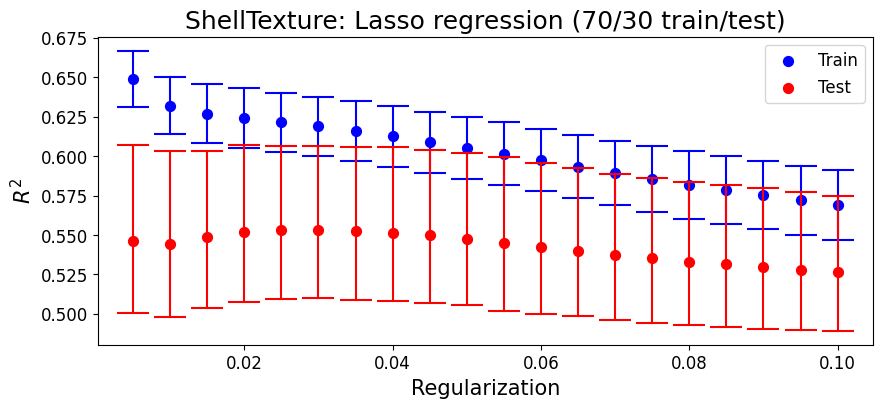

In [14]:
reg = str(type(ridge)).split('.')[-1][:-2]
fs = 15
fig, ax = plt.subplots(1,1,figsize=(10,4))
ax = np.atleast_1d(ax).ravel(); i=0
c = ['blue','red']
l = ['Train','Test']
for j in range(2):
    ax[i].scatter(alphas, describe[:,1,j], color=c[j], label=l[j], s=50)
    ax[i].scatter(alphas, describe[:,4,j], color=c[j], marker='_', s=500)
    ax[i].scatter(alphas, describe[:,6,j], color=c[j], marker='_', s=500)
    for k in range(len(alphas)):
        ax[i].plot([alphas[k], alphas[k]], describe[k,[4,6],j], color=c[j])

ax[i].set_ylabel('$R^2$', fontsize=fs, rotation=90)
ax[i].set_xlabel('Regularization', fontsize=fs)
ax[i].tick_params(labelsize=fs-3)
ax[i].set_title(yvalue + ': ' + reg +' regression (70/30 train/test)', fontsize=fs+3)
ax[i].legend(fontsize=fs-3);

filename = dst + yvalue.lower() + '_' + reg.lower()+ '_7030_optimal'
plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

# Fix $\alpha$ and explore the most relevant coefficients

In [15]:
N = 1000
alpha = alphas[np.argmax(describe[:,1,1])]
R2 = np.zeros((N,2))
coefs = np.zeros((N,X.shape[1]))

for i in range(N):    
    X_train, y_train = X[choice[i]].copy(), y[choice[i]].copy()
    X_test, y_test = X[nonchoice[i]].copy(), y[nonchoice[i]].copy()

    ridge = lmodel.Lasso(alpha=alpha).fit(X_train, y_train)
    r2_train = ridge.score(X_train, y_train)

    y_pred = ridge.predict(X_test)
    r2_test = mets.r2_score(y_test, y_pred)
    R2[i] = [r2_train, r2_test]
    coefs[i] = ridge.coef_

../hpcc/results/trad/shelltexture_optimal_lasso_R2_train_vs_test


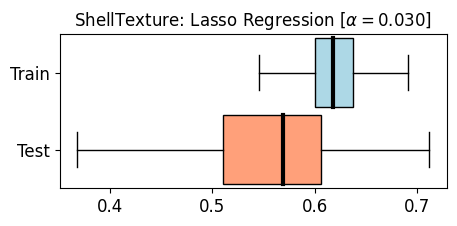

In [17]:
fs = 12
reg = str(type(ridge)).split('.')[-1][:-2]

fig, ax = plt.subplots(1,1,figsize=(5,2))
colors = ['lightsalmon','lightblue']
bplot = ax.boxplot(np.flip(R2), notch=False, sym='', vert=False, widths=0.9, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'}, labels=['Test', 'Train'])

for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
        
ax.set_title(yvalue + ': ' + reg + ' Regression [$\\alpha=${:.3f}]'.format(ridge.alpha), fontsize=fs);
ax.tick_params(labelsize=fs)
filename = dst + yvalue.lower() + '_optimal_' + reg.lower() + '_R2_train_vs_test'
plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

../hpcc/results/trad/shelltexture_lasso_coefs


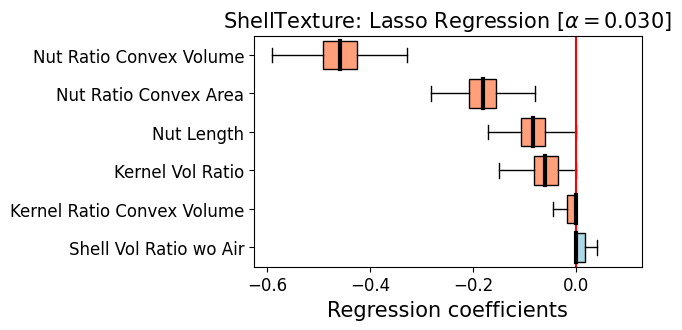

In [20]:
fs = 15
fabs = np.abs(np.mean(coefs, axis=0))
r_mask = fabs > 0.01
aabs = np.argsort(fabs[r_mask])
mabs = np.mean(coefs[:,r_mask][:,aabs], axis=0)

fig, ax = plt.subplots(1,1,figsize=(5,3))

colors = ['lightsalmon','lightblue']

bplot = ax.boxplot(coefs[:,r_mask][:,aabs], notch=False, sym='', vert=False, widths=0.75, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'},
                   labels = labels.col_labels.iloc[iniN+s_mask].iloc[r_mask].iloc[aabs])
ax.scatter([-np.max(coefs), np.max(coefs)], [5,5], c='w', alpha=0)

for i,patch in enumerate(bplot['boxes']):
    if mabs[i] > 0:
        patch.set_facecolor(colors[1])
    else:
        patch.set_facecolor(colors[0])

ax.axvline(0, c='r')
ax.set_title(yvalue + ': ' + reg + ' Regression [$\\alpha=${:.3f}]'.format(ridge.alpha), fontsize=fs)
ax.set_xlabel('Regression coefficients', fontsize=fs)
ax.tick_params(labelsize=fs-3)

filename = dst + yvalue.lower() + '_' + reg.lower() + '_coefs'
plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

# Feature selection

In [21]:
X = Xscaler.transform(data.iloc[:,iniN + s_mask].values.copy())
X = X[:, r_mask]

N = 100
M = X.shape[1]

dict22 = [{} for i in range(M)]


for i in range(X.shape[1]):
    R2 = np.zeros((N,2))
    X1 = X[:,i].copy()

    for j in range(N):
        X_train, y_train = X1[choice[j]].copy().reshape(-1,1), y[choice[j]].copy()
        X_test, y_test = X1[nonchoice[j]].copy().reshape(-1,1), y[nonchoice[j]].copy()

        ridge = lmodel.LinearRegression().fit(X_train, y_train)
        R2[j,0] = ridge.score(X_train, y_train)

        y_pred = ridge.predict(X_test)
        R2[j,1] = mets.r2_score(y_test, y_pred)

    dict22[0][(i,)] = R2

In [22]:
for i in range(1,M):
    for comb in it.combinations(range(X.shape[1]), i+1):
        R2 = np.zeros((N,2))
        arrcomb = np.array(comb)
        X1 = X[:,arrcomb].copy()
        
        for j in range(N):
            X_train, y_train = X1[choice[j]].copy(), y[choice[j]].copy()
            X_test, y_test = X1[nonchoice[j]].copy(), y[nonchoice[j]].copy()

            ridge = lmodel.Lasso(alpha=alpha).fit(X_train, y_train)
            R2[j,0] = ridge.score(X_train, y_train)

            y_pred = ridge.predict(X_test)
            R2[j,1] = mets.r2_score(y_test, y_pred)
            
        dict22[i][comb] = R2

../hpcc/results/trad/shelltexture_lasso_7030


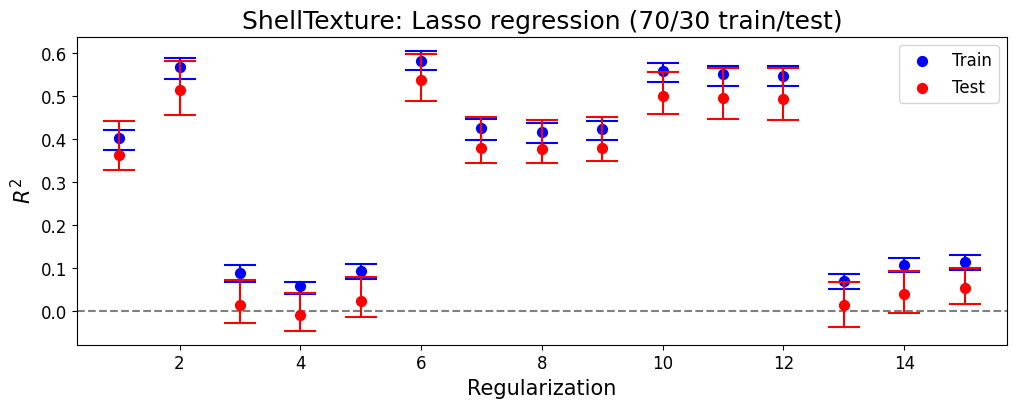

In [23]:
k = 1
describe = np.zeros((len(dict22[k]), 8, 2 ))
for i,key in enumerate(dict22[k]):
    describe[i] = pd.DataFrame(dict22[k][key]).describe().values

fs = 15
xaxis = np.arange(len(describe)) + 1
fig, ax = plt.subplots(1,1,figsize=(12,4))
ax = np.atleast_1d(ax).ravel(); i=0

c = ['blue','red']
l = ['Train','Test']

for j in range(2):
    ax[i].scatter(xaxis, describe[:,1,j], color=c[j], label=l[j], s=50)
    ax[i].scatter(xaxis, describe[:,4,j], color=c[j], marker='_', s=500)
    ax[i].scatter(xaxis, describe[:,6,j], color=c[j], marker='_', s=500)
    for k in range(len(xaxis)):
        ax[i].plot([xaxis[k], xaxis[k]], describe[k,[4,6],j], color=c[j])

ax[i].axhline(0, c='gray', ls='--', zorder=-1)
ax[i].set_ylabel('$R^2$', fontsize=fs, rotation=90)
ax[i].set_xlabel('Regularization', fontsize=fs)
ax[i].tick_params(labelsize=fs-3)
ax[i].set_title(yvalue + ': ' + reg +' regression (70/30 train/test)', fontsize=fs+3)
ax[i].legend(fontsize=fs-3);

filename = dst + yvalue.lower() + '_' + reg.lower()+ '_7030'
#plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
#plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')
print(filename)

In [24]:
maxR2 = [{} for i in range(M)]
maxargs = [None for i in range(M)]
maxvals = np.zeros(M)

for k in range(len(maxR2)):
    for key in dict22[k]:
        maxR2[k][key] = np.mean(dict22[k][key], axis = 0)

    maxval = 0
    for key in dict22[k]:
        val = maxR2[k][key][1]
        if val > maxval:
            maxval = val
            maxarg = key
    
    maxargs[k] = maxarg
    maxvals[k] = maxval
    
    print(maxarg, maxval, maxR2[k][maxarg])
    print(labels.col_labels.iloc[iniN + s_mask].iloc[r_mask].iloc[np.array(maxarg)], '\n')

(2,) 0.4965373519405527 [0.5458255  0.49653735]
14    Nut Ratio Convex Volume
Name: col_labels, dtype: object 

(1, 2) 0.537024617677312 [0.58276788 0.53702462]
13      Nut Ratio Convex Area
14    Nut Ratio Convex Volume
Name: col_labels, dtype: object 

(0, 1, 2) 0.5484108775507319 [0.60042933 0.54841088]
3                  Nut Length
13      Nut Ratio Convex Area
14    Nut Ratio Convex Volume
Name: col_labels, dtype: object 

(0, 1, 2, 3) 0.5545715635102106 [0.61766681 0.55457156]
3                  Nut Length
13      Nut Ratio Convex Area
14    Nut Ratio Convex Volume
22           Kernel Vol Ratio
Name: col_labels, dtype: object 

(0, 1, 2, 3, 4) 0.552111855411962 [0.61831321 0.55211186]
3                     Nut Length
13         Nut Ratio Convex Area
14       Nut Ratio Convex Volume
22              Kernel Vol Ratio
36    Kernel Ratio Convex Volume
Name: col_labels, dtype: object 

(0, 1, 2, 3, 4, 5) 0.5493765640147704 [0.6194702  0.54937656]
3                     Nut Length
13    

In [25]:
boxtrain = np.zeros((N,M))
boxtest  = np.zeros((N,M))

for k in range(M):
    boxtrain[:,k] = dict22[k][maxargs[k]][:,0]
    boxtest[:,k] = dict22[k][maxargs[k]][:,1]

In [26]:
img = np.zeros((M,M), dtype=bool)
for k in range(M):
    img[k, np.array(maxargs[k])] = True
    
foo = np.array(np.nonzero(img.T))
foo = np.array([np.min(foo[:, foo[0]==k][1]) for k in range(M)])*.1
argsum = np.argsort(np.sum(img, axis=0) - foo)[::-1]

../hpcc/results/trad/shelltexture_OLS_optimal_features


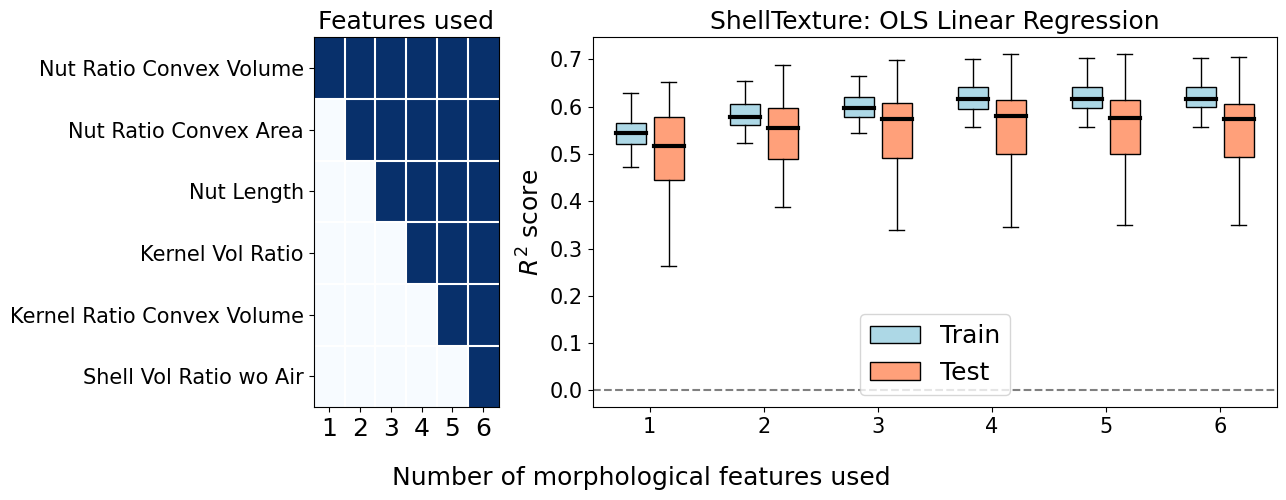

In [27]:
fs = 18
vert = True

fig, ax = plt.subplots(1,2,figsize=(13,5), width_ratios=[1,3])
ax = np.atleast_1d(ax).ravel()

i = 0

ax[i].imshow(img.T[argsum], cmap='Blues')
for k in range(M-1):
    ax[i].axhline(k+0.5, c='w')
    ax[i].axvline(k+0.5, c='w')

ax[i].set_aspect(2)
ax[i].set_yticks(range(M), labels.col_labels.iloc[iniN + s_mask].iloc[r_mask].iloc[argsum].values, fontsize=fs-3)
ax[i].set_xticks(range(M), 1+np.arange(M), fontsize=fs);
ax[i].set_title('Features used', fontsize=fs)

i = 1

bp1 = ax[i].boxplot(boxtrain, notch=False, sym='', vert=vert, widths=0.4, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'}, positions=1.5*np.arange(M)-0.25)
for patch in bp1['boxes']:
        patch.set_facecolor(colors[1])
        
bp2 = ax[i].boxplot(boxtest, notch=False, sym='', vert=vert, widths=0.4, patch_artist=True,
                   medianprops={'lw':3, 'color':'k'}, positions=1.5*np.arange(M)+0.25)
for patch in bp2['boxes']:
        patch.set_facecolor(colors[0])
ax[i].legend([bp1["boxes"][0], bp2["boxes"][0]], ['Train', 'Test'], loc='lower center', fontsize=fs)
ax[i].axhline(0, c='gray', zorder=0, ls='--')
ax[i].set_xticks(1.5*np.arange(M), 1+np.arange(M))
ax[i].set_ylabel('$R^2$ score', fontsize=fs)
ax[i].tick_params(labelsize=fs-3);
ax[i].set_title(yvalue + ': OLS Linear Regression', fontsize=fs)

fig.supxlabel('Number of morphological features used', fontsize=fs)

fig.tight_layout();

filename = dst + yvalue.lower() + '_OLS_optimal_features'
print(filename)
plt.savefig(filename + '.jpg', dpi=150, bbox_inches='tight', pil_kwargs = {'optimize':True}, format='jpg')
plt.savefig(filename + '.pdf', format='pdf', bbox_inches='tight')

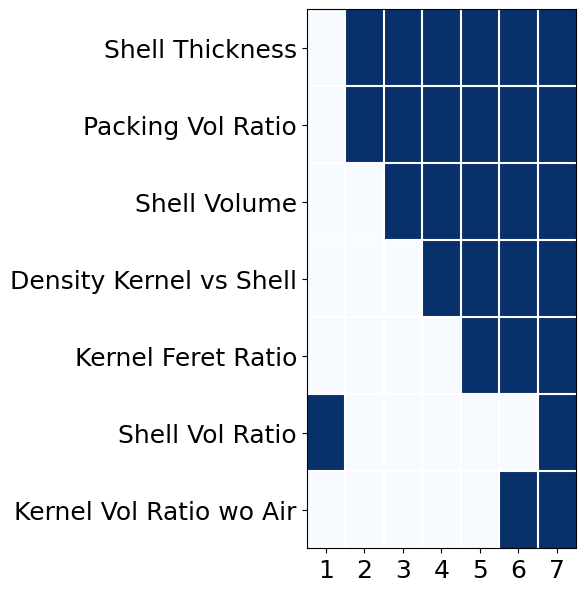

In [27]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax = np.atleast_1d(ax).ravel(); i=0

ax[i].imshow(img.T[argsum], cmap='Blues')
for k in range(M-1):
    ax[i].axhline(k+0.5, c='w')
    ax[i].axvline(k+0.5, c='w')

ax[i].set_aspect(2)
ax[i].set_yticks(range(M), labels.col_labels.iloc[iniN + s_mask].iloc[r_mask].iloc[argsum].values, fontsize=fs)
ax[i].set_xticks(range(M), 1+np.arange(M), fontsize=fs);
#ax[i].tick_params(top=True, labeltop=True, bottom=False, labelbottom=False);